In [1]:
!python -V
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from typing import Callable


rng = np.random.default_rng(1234)

Python 3.13.3


# Question 1

## (a)

For the model

$$ dX_t = rX_t dt + \sigma X_{t}^\gamma dW_t $$

We note that the associated PDE for the corridor option price $V(t, x)$ is

$$
\begin{align*}
    &\frac{\partial V}{\partial t} + rx \frac{\partial V}{\partial x} + \frac{\sigma^2 x^{2\gamma}}{2} \frac{\partial^2 V}{\partial x^2} - rV = 0 \\
    &\\
    &V(T, x) = 𝟙_{[15, 25]} (x)
\end{align*}
$$

We recall that $V^{m}_{n} = V(m\Delta t, x_\mathrm{min} + n \Delta x)$ and the discretizations for the implicit scheme is given by

$$
\begin{align*}
    \frac{\partial V}{\partial t} &\approx \frac{V^{m}_{n} - V^{m-1}_{n}}{\Delta t} \\
    \frac{\partial V}{\partial x} &\approx \frac{V^{m-1}_{n+1} - V^{m-1}_{n-1}}{2\Delta x} \\
    \frac{\partial^2 V}{\partial x^2} & \approx \frac{V^{m-1}_{n+1} - 2V^{m-1}_{n} + V^{m-1}_{n-1}}{(\Delta x)^2}
\end{align*}
$$

Setting $\chi_n = x_\mathrm{min} + n\Delta x$, this yields the discretization

$$
    \frac{1}{\Delta t} \left( V^{m}_{n} - V^{m-1}_{n} \right) + \frac{r\chi_n}{2\Delta x} \left( V^{m-1}_{n+1} - V^{m-1}_{n-1} \right) + \frac{\sigma^2 \chi_{n}^{2\gamma}}{2(\Delta x)^2} \left( V^{m-1}_{n+1} - 2V^{m-1}_{n} + V^{m-1}_{n-1} \right) - rV^{m-1}_{n} = 0
$$

Now set $\alpha_n = \frac{r \chi_n \Delta t}{2\Delta x}$, $\beta_n = \frac{\sigma^2 \chi_{n}^{2\gamma} \Delta t}{2\Delta x^2}$. Then we arrive at the scheme

$$
\begin{align*}
    V^{m}_{n} &= V^{m-1}_{n-1} \left(\alpha_n - \beta_n \right) \\
    &+ V^{m-1}_{n} \left(1 + r \Delta t + 2\beta_n \right) \\
    &+ V^{m-1}_{n+1} \left(-\alpha_n - \beta_n \right)
\end{align*}
$$
For the boundary conditions, we will use the fact that $V(t, x) = 0$ when $x \notin [15, 25]$, which translates to $V_{N+1}^{k} = V_{0}^{k} = 0$.

Note that this scheme is essentially the linear system $Av^{m-1} = v^{m}$ where the only unknown is $v^{m-1}$.

In [2]:
def implicit_solver(
        *,
        dt: float,
        dx: float,
        r: float,
        gamma: float,
        sigma: float,
        T: float,
        x_range: tuple[float, float],
        payoff: np.ndarray | None = None,
        boundary: Callable[[int], tuple[float, float]] = lambda x: (0, 0)
) -> np.ndarray:
        '''
        x_range is interpreted as `[X_min, X_max]`. Necessarily, x0 should be in x_range.

        This assumes that `T / dt` and `(X_max - X_min) / dx` are integers.

        Payoff is an optional parameter. If not given, then the payoff will be assumed to be 1.
        '''
        # initialize grid and initial conditions
        x_min, x_max = x_range
        M = int(T / dt)
        N = int((x_max - x_min) / dx) + 1

        grid = np.empty((N, M))
        grid[:, -1] = payoff if payoff is not None else np.ones(N)

        # find the matrix A s.t. Av^{m-1} = v^m
        # instead of constructing A explicitly,
        # i will use scipy's "solve_banded" method
        # which requires a 3 x N matrix.
        n = np.arange(1, N+1) # 1, 2, ..., N
        chi = x_min + n * dx
        alpha = (r * chi * dt) / (2 * dx)
        beta = (sigma**2 * chi**(2 * gamma) * dt) / (2 * dx**2)

        upper_diagonal = -alpha - beta
        upper_diagonal = np.delete(upper_diagonal, -1) # remove the last term since it doesn't appear in the scheme
        upper_diagonal = np.insert(upper_diagonal, 0, 0) # for scipy

        diagonal = 1 + r * dt + 2 * beta

        lower_diagonal = alpha - beta
        lower_diagonal = np.delete(lower_diagonal, 0) # remove the first term since it doesn't appear in the scheme
        lower_diagonal = np.append(lower_diagonal, 0) # for scipy

        A_scipy = np.vstack((upper_diagonal, diagonal, lower_diagonal))
        
        # run the scheme
        b = np.zeros(N)
        for i in range(M - 1, 0, -1): # M - 1, ..., 1
                b[0], b[-1] = boundary(i)
                grid[:, i-1] = sp.linalg.solve_banded((1, 1), A_scipy, grid[:, i] + b)

        return grid

In [3]:
implicit_solution = implicit_solver(
    dt=0.01,
    dx=0.02,
    r=0.05,
    gamma=0.8,
    sigma=0.4,
    T=0.5,
    x_range=(15, 25)
)

Implicit: Option Price at t=0, x=20: $0.7661


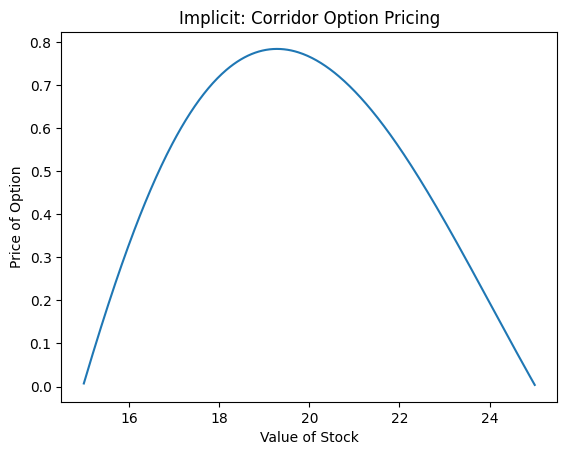

In [4]:
# graph the solution
# 20 = 15 + k 0.02 so k = 5 / 0.02 = 250
print(f'Implicit: Option Price at t=0, x=20: ${implicit_solution[250, 0]:.4f}')

ax = sns.lineplot(x=np.linspace(15, 25, 501), y=implicit_solution[:, 0])
ax.set_xlabel('Value of Stock')
ax.set_ylabel('Price of Option')
ax.set_title('Implicit: Corridor Option Pricing')

plt.show()

## (b)

For the Crank-Nicolson method, we have the following discretization
$$
\begin{align*}
    &\frac{V^{m}_{n} - V^{m-1}_{n}}{\Delta t} +\\
    &r\chi_n \cdot \frac{1}{2} \left( \frac{V^{m-1}_{n+1} - V^{m-1}_{n-1}}{2\Delta x} + \frac{V^{m}_{n+1} - V^{m}_{n-1}}{2\Delta x} \right) +\\
    &\frac{\sigma^2 \chi_{n}^{2\gamma}}{2} \cdot \frac{1}{2} \left( \frac{V^{m-1}_{n+1} - 2V^{m-1}_{n} + V^{m-1}_{n-1}}{(\Delta x)^2} + \frac{V^{m}_{n+1} - 2V^{m}_{n} + V^{m}_{n-1}}{(\Delta x)^2} \right) + \\ 
    &-r \cdot \frac{1}{2}\left( V^{m-1}_{n}  + V^{m}_{n} \right) = 0
\end{align*}
$$

Keeping the definitions $\alpha_n = \frac{r \chi_n \Delta t}{2\Delta x}$, $\beta_n = \frac{\sigma^2 \chi_{n}^{2\gamma} \Delta t}{2\Delta x^2}$, we have the scheme

$$
\begin{align*}
    &V^{m-1}_{n-1} \left(\frac{\alpha_n}{2} - \frac{\beta_n}{2} \right) + V^{m-1}_{n} \left(1 + \frac{r \Delta t}{2} + \beta_n \right) + V^{m-1}_{n+1} \left(-\frac{\alpha_n}{2} - \frac{\beta_n}{2} \right) \\
    =&V^{m}_{n-1} \left( -\frac{\alpha_n}{2} + \frac{\beta_n}{2} \right) + V^{m}_{n} \left(1 - \frac{r \Delta t}{2} - \beta_n \right) + V^{m}_{n+1} \left(\frac{\alpha_n}{2} + \frac{\beta_n}{2}\right)
\end{align*}
$$

We will keep the boundary condition $V^{k}_{N+1} = V^{k}_{0} = 0$ for every $k$.

Note that this scheme is essentially the linear system $Av^{m-1} = Bv^m$ where the only unknown is $v^{m-1}$

In [5]:
def crank_nicolson_solver(
    *,
    dt: float,
    dx: float,
    r: float,
    gamma: float,
    sigma: float,
    T: float,
    x_range: tuple[float, float],
    payoff: np.ndarray | None = None,
    boundary: Callable[[int], tuple[float, float]] = lambda x: (0, 0)
) -> np.ndarray:
    '''
    x_range is interpreted as `[X_min, X_max]`. Necessarily, x0 should be in x_range.
    This assumes that `T / dt` and `(X_max - X_min) / dx` are integers.
    
    Payoff is an optional parameter. If not given, then the payoff will assumed to be 1.

    Boundary is an optional parameter. It is a function that is given the current index and returns
    the boundary conditions for (0, N+1), which is then added to the RHS of the linear system. Defaults to 0.
    '''
    # initialize grid and initial conditions
    x_min, x_max = x_range
    M = int(T / dt)
    N = int((x_max - x_min) / dx) + 1

    grid = np.empty((N, M))
    payoff = payoff if payoff is not None else np.ones(N)
    grid[:, -1] = payoff

    # find the matrix A
    # instead of constructing A explicitly,
    # i will use scipy's "solve_banded" method
    # which requires a 3 x N matrix.
    n = np.arange(1, N+1) # 1, 2, ..., N
    chi = x_min + n * dx
    alpha = (r * chi * dt) / (2 * dx)
    beta = (sigma**2 * chi**(2 * gamma) * dt) / (2 * dx**2)

    A_upper_diagonal = -(alpha + beta) / 2
    A_upper_diagonal = np.delete(A_upper_diagonal, -1) # remove the last term since it doesn't appear in the scheme

    A_diagonal = 1 + r * dt / 2 + beta

    A_lower_diagonal = (alpha - beta) / 2
    A_lower_diagonal = np.delete(A_lower_diagonal, 0) # remove the first term since it doesn't appear in the scheme

    A_scipy = np.vstack( # the modifications of the diagonals is purely for formatting purposes
        (
            np.insert(A_upper_diagonal, 0, 0), 
            A_diagonal, 
            np.append(A_lower_diagonal, 0)
        )
    )

    # now construct B
    B_upper_diagonal = (alpha + beta) / 2
    B_upper_diagonal = np.delete(B_upper_diagonal, -1) # remove last term

    B_diagonal = 1 - r * dt / 2 - beta

    B_lower_diagonal = (-alpha + beta) / 2
    B_lower_diagonal = np.delete(B_lower_diagonal, 0) # remove first term

    B = np.diag(B_diagonal) + np.diag(B_upper_diagonal, k=1) + np.diag(B_lower_diagonal, k=-1)

    b = np.zeros(N)
    for i in range(M - 1, 0, -1): # M - 1, ..., 1
        b[0], b[-1] = boundary(i)
        RHS = B @ grid[:, i] + b
        RHS[0], RHS[-1] = RHS[1], RHS[-2] 
        # the edges are extremely unstable, this solution basically zeroes out the derivative
        # very ad hoc but zeroing out the endpoint just brought the problem to the penultimate point
        # see part (c)'s CN implementation for more comments
        grid[:, i-1] = sp.linalg.solve_banded((1, 1), A_scipy, RHS)

    return grid

In [6]:
cn_solution = crank_nicolson_solver(
    dt=0.01,
    dx=0.02,
    r=0.05,
    gamma=0.8,
    sigma=0.4,
    T=0.5,
    x_range=(15, 25)
)

Crank-Nicolson: Option Price at t=0, x=20: $0.7687


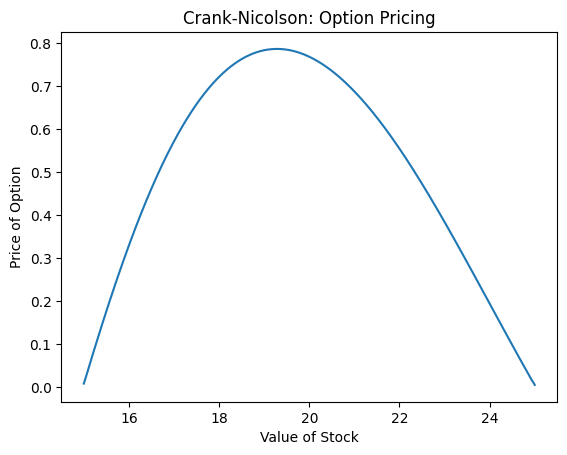

In [7]:
# graph the solution
# 20 = 15 + k 0.02 so k = 5 / 0.02 = 250
print(f'Crank-Nicolson: Option Price at t=0, x=20: ${cn_solution[250, 0]:.4f}')

ax = sns.lineplot(x=np.linspace(15, 25, 501), y=cn_solution[:, 0])
ax.set_xlabel('Value of Stock')
ax.set_ylabel('Price of Option')
ax.set_title('Crank-Nicolson: Option Pricing')

plt.show()

We note that there is some numerical instability since, for $\Delta t = 0.01$ and $\Delta x = 0.02$, $\frac{\Delta t}{\Delta x^2} = 25 > \frac{1}{2}$. Despite this, both solvers are within 1 cent of each other at $V(0, 20)$, so they perform roughly the same in this region (with the implicit solver having better global performance). 

Compared to Q1 from HW1, all Monte Carlo solvers estimated an interval of about $[0.79, 0.81]$, whose mean is about 4 cents greater than both PDE estimates. The estimates are fairly close, but notably there is a small bias between the two.

## (c)

To simulate the compound option, we first must simulate the underlying call option prices. This has payoff

$$
    \max\{ x - 20, 0\}
$$

I will use the boundary condition $\frac{\partial^2 C}{\partial x^2} = 0$ on both boundaries, as this condition makes intuitive sense since call options become roughly linear at the endpoints, and the price of a CEV call has no closed form. This amounts to $C^{k}_{N+1} = 2C^{k}_{N} - C^{k}_{N-1}$, $C^{k}_{0} = 2C^{k}_{1} - C^{k}_{2}$.

Moreover, I will use the range $[10, 30]$, $\Delta x = 0.02, \Delta t = 0.01$. This amounts to 1001 points for $x$

In [8]:
# the 2nd derivative condition requires me to directly edit the matrix unfortunately,
# so i have to slightly modify them in the solver
def compound_implicit_solver(
        *,
        dt: float,
        dx: float,
        r: float,
        gamma: float,
        sigma: float,
        T: float,
        x_range: tuple[float, float],
        payoff: np.ndarray | None = None,
        boundary: Callable[[int], tuple[float, float]] = lambda x: (0, 0)
) -> np.ndarray:
        '''
        x_range is interpreted as `[X_min, X_max]`. Necessarily, x0 should be in x_range.

        This assumes that `T / dt` and `(X_max - X_min) / dx` are integers.

        Payoff is an optional parameter. If not given, then the payoff will be assumed to be 1.
        '''
        # initialize grid and initial conditions
        x_min, x_max = x_range
        M = int(T / dt)
        N = int((x_max - x_min) / dx) + 1

        grid = np.empty((N, M))
        grid[:, -1] = payoff if payoff is not None else np.ones(N)

        # find the matrix A s.t. Av^{m-1} = v^m
        # instead of constructing A explicitly,
        # i will use scipy's "solve_banded" method
        # which requires a 3 x N matrix.
        n = np.arange(1, N+1) # 1, 2, ..., N
        chi = x_min + n * dx
        alpha = (r * chi * dt) / (2 * dx)
        beta = (sigma**2 * chi**(2 * gamma) * dt) / (2 * dx**2)

        upper_diagonal = -alpha - beta
        c_upper_term = upper_diagonal[-1]
        upper_diagonal = np.delete(upper_diagonal, -1) # remove the last term since it doesn't appear in the scheme
        upper_diagonal = np.insert(upper_diagonal, 0, 0) # for scipy

        diagonal = 1 + r * dt + 2 * beta

        lower_diagonal = alpha - beta
        c_lower_term = lower_diagonal[0]
        lower_diagonal = np.delete(lower_diagonal, 0) # remove the first term since it doesn't appear in the scheme
        lower_diagonal = np.append(lower_diagonal, 0) # for scipy

        # incorporate the boundary conditions into A
        # upper boundary
        diagonal[-1] += 2 * c_upper_term
        lower_diagonal[-2] -= c_upper_term

        # lower boundary
        diagonal[0] += 2 * c_lower_term
        upper_diagonal[1] -= c_lower_term
        A_scipy = np.vstack((upper_diagonal, diagonal, lower_diagonal))
        
        # run the scheme
        b = np.zeros(N)
        for i in range(M - 1, 0, -1): # M - 1, ..., 1
                b[0], b[-1] = boundary(i)
                grid[:, i-1] = sp.linalg.solve_banded((1, 1), A_scipy, grid[:, i] + b)

        return grid

In [9]:
def compound_crank_nicolson_solver(
    *,
    dt: float,
    dx: float,
    r: float,
    gamma: float,
    sigma: float,
    T: float,
    x_range: tuple[float, float],
    payoff: np.ndarray | None = None,
    boundary: Callable[[int], tuple[float, float]] = lambda x: (0, 0)
) -> np.ndarray:
    '''
    x_range is interpreted as `[X_min, X_max]`. Necessarily, x0 should be in x_range.
    This assumes that `T / dt` and `(X_max - X_min) / dx` are integers.
    
    Payoff is an optional parameter. If not given, then the payoff will be assumed to be 1.
    
    Boundary is an optional parameter. It is a function that is given the current index and returns
    the boundary conditions for (0, N+1), which is then added to the RHS of the linear system. Defaults to 0.
    '''
    # initialize grid and initial conditions
    x_min, x_max = x_range
    M = int(T / dt)
    N = int((x_max - x_min) / dx) + 1

    grid = np.empty((N, M))
    grid[:, -1] = payoff if payoff is not None else np.ones(N)

    # find the matrix A
    # instead of constructing A explicitly,
    # i will use scipy's "solve_banded" method
    # which requires a 3 x N matrix.
    n = np.arange(1, N+1) # 1, 2, ..., N
    chi = x_min + n * dx
    alpha = (r * chi * dt) / (2 * dx)
    beta = (sigma**2 * chi**(2 * gamma) * dt) / (2 * dx**2)

    A_upper_diagonal = (-alpha - beta) / 2
    c_upper_term = A_upper_diagonal[-1]
    A_upper_diagonal = np.delete(A_upper_diagonal, -1) # remove the last term since it doesn't appear in the scheme

    A_diagonal = 1 + r * dt / 2 + beta

    A_lower_diagonal = (alpha - beta) / 2
    c_lower_term = A_lower_diagonal[0]
    A_lower_diagonal = np.delete(A_lower_diagonal, 0) # remove the first term since it doesn't appear in the scheme

    # incorporate the boundary conditions into A
    # upper boundary
    A_diagonal[-1] += 2 * c_upper_term
    A_lower_diagonal[-1] -= c_upper_term

    # lower boundary
    A_diagonal[0] += 2 * c_lower_term
    A_upper_diagonal[1] -= c_lower_term

    A_scipy = np.vstack( # the modifications of the diagonals is purely for formatting purposes
        (
            np.insert(A_upper_diagonal, 0, 0), 
            A_diagonal, 
            np.append(A_lower_diagonal, 0)
        )
    )

    # now construct B
    B_upper_diagonal = -A_upper_diagonal
    B_diagonal = 1 - r * dt / 2 - beta
    B_lower_diagonal = -A_lower_diagonal

    B = np.diag(B_diagonal) + np.diag(B_upper_diagonal, k=1) + np.diag(B_lower_diagonal, k=-1)

    b = np.zeros(N)
    for i in range(M - 1, 0, -1): # M - 1, ..., 1
        b[0], b[-1] = boundary(i)
        RHS = B @ grid[:, i] + b
        RHS[0], RHS[-1] = RHS[1], RHS[-2]
        # i haven't been able to figure this out...
        # zeroing out the last point just brings the same weird problem of exploding boundaries
        # to the penultimate point
        grid[:, i-1] = sp.linalg.solve_banded((1, 1), A_scipy, RHS)

    return grid

In [10]:
payoff = np.linspace(10, 30, 1001) - 20
payoff[payoff < 0] = 0 

implicit_call_prices = compound_implicit_solver(
    dt=0.01,
    dx=0.02,
    r=0.05,
    gamma=0.8,
    sigma=0.4,
    T=0.5,
    x_range=(10, 30),
    payoff=payoff
)

cn_call_prices = compound_crank_nicolson_solver(
    dt=0.01,
    dx=0.02,
    r=0.05,
    gamma=0.8,
    sigma=0.4,
    T=0.5,
    x_range=(10, 30),
    payoff=payoff
)

Now for the compound option $K$, we will use the payoff

$$
    \max\{c - 2, 0\}
$$
Where $c$ is the price of the call option at $t = 1/4$. Note that $k\Delta t = 1/4 \iff k = \frac{1}{4\Delta t} = 25$ 

In [11]:
implicit_payoff = implicit_call_prices[:, 24] - 2
implicit_payoff[implicit_payoff < 0] = 0

cn_payoff = cn_call_prices[:, 24] - 2
cn_payoff[cn_payoff < 0] = 0

compound_implicit_prices = compound_implicit_solver(
    dt=0.01,
    dx=0.02,
    r=0.05,
    gamma=0.8,
    sigma=0.4,
    T=0.25,
    x_range=(10, 30),
    payoff=implicit_payoff
)

cn_implicit_prices = compound_crank_nicolson_solver(
    dt=0.01,
    dx=0.02,
    r=0.05,
    gamma=0.8,
    sigma=0.4,
    T=0.25,
    x_range=(10, 30),
    payoff=cn_payoff
)

<Axes: >

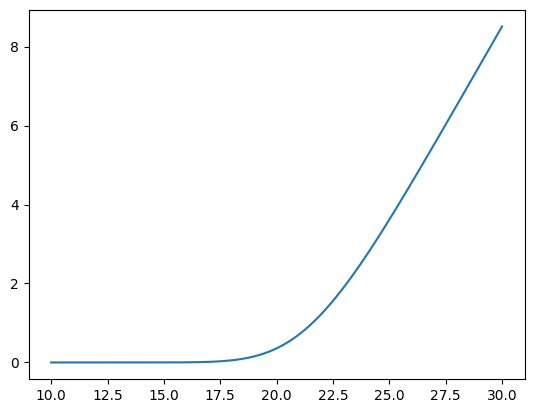

In [12]:
sns.lineplot(x=np.linspace(10, 30, 1001), y=compound_implicit_prices[:, 0])

<Axes: >

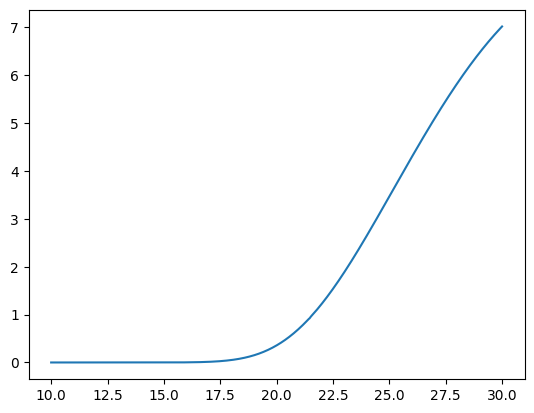

In [13]:
sns.lineplot(x=np.linspace(10, 30, 1001), y=cn_implicit_prices[:, 0])

In [27]:
print(f'Implicit Solution at t=0, X0=20: {compound_implicit_prices[500, 0]:.4f}')
print(f'Crank-Nicolson Solution at t=0, X0=20: {cn_implicit_prices[500, 0]:.4f}')

Implicit Solution at t=0, X0=20: 0.3580
Crank-Nicolson Solution at t=0, X0=20: 0.3570


# Question 2

## (a)

For the model
$$
    \begin{align*}
        &dS_t = rS_t dt + S_t \sqrt{V_t} dW^{1}_t \\
        &dV_t = \kappa (\theta - V_t) dt + \eta \sqrt{V_t} dW^{2}_t \\
        &d\langle W^{1}_{t}, W^{2}_t \rangle = \rho
    \end{align*}
$$

We have that the price for a Put option $P(t, s, v)$ satisfies
$$
    \begin{align*}
        &\frac{\partial P}{\partial t} + rs \frac{\partial P}{\partial s} + s^2 v \frac{\partial^2 P}{\partial s^2} +\\
        &\kappa(\theta - v) \frac{\partial P}{\partial v} + \eta^2 v \frac{\partial^2 P}{\partial v^2} + \rho \eta sv \frac{\partial^2 P}{\partial s \partial v} - rP = 0
    \end{align*}
$$

Set $P^{m}_{n, \ell} = P(m\Delta t, s_\mathrm{min} + n\Delta s, v_\mathrm{min} + \ell \Delta v )$ and $\zeta_n = s_\mathrm{min} + n\Delta s$, $\nu_\ell = v_\mathrm{min} + \ell \Delta v$. Then we have the discretization

$$
    \begin{align*}
        &\frac{P^{m}_{n, \ell} - P^{m-1}_{n, \ell}}{\Delta t} + r\zeta_n \frac{P^{m}_{n+1, \ell} - P^{m}_{n-1, \ell}}{2\Delta s} + \zeta^{2}_{n} \nu_\ell \frac{P^{m}_{n+1, \ell} - 2P^{m}_{n, \ell} + P^{m}_{n-1, \ell}}{\Delta s^2} + \\
        &\kappa (\theta - \nu_\ell) \frac{P^{m}_{n, \ell + 1} - P^{m}_{n, \ell - 1}}{2\Delta v} + \eta^2 \nu_\ell \frac{P^{m}_{n, \ell + 1} - 2P^{m}_{n, \ell} + P^{m}_{n, \ell - 1}}{\Delta v^2} + \\
        &\rho \eta \zeta_n v_\ell \frac{P^{m}_{n+1, \ell + 1} - P^{m}_{n + 1, \ell - 1} + P^{m}_{n-1, \ell + 1} - P^{m}_{n-1, \ell - 1}}{4\Delta s \Delta v} - rP^{m}_{n, \ell} = 0
    \end{align*}
$$

This yields the scheme

$$
    \begin{align*}
        P^{m-1}_{n, \ell} = &P^{m}_{n, \ell} \left(1 - \frac{2\zeta^{2}_{n} \nu_\ell \Delta t}{\Delta s^2}  - \frac{2\eta^2 \nu_\ell \Delta t}{\Delta v^2} - r \Delta t \right) + \\
        &P^{m}_{n+1, \ell} \left( \frac{r\zeta_n \Delta t}{2 \Delta s} + \frac{\zeta^{2}_{n} \nu_\ell \Delta t}{\Delta s^2} \right) + \\
        &P^{m}_{n-1, \ell} \left( -\frac{r\zeta_n \Delta t}{2 \Delta s} + \frac{\zeta^{2}_{n} \nu_\ell \Delta t}{\Delta s^2} \right) + \\
        &P^{m}_{n, \ell + 1} \left( \frac{\kappa(\theta - \nu_\ell) \Delta t}{2\Delta v} + \frac{\eta^2 \nu_\ell \Delta t}{\Delta v^2} \right) + \\
        &P^{m}_{n, \ell - 1} \left( -\frac{\kappa(\theta - \nu_\ell) \Delta t}{2\Delta v} + \frac{\eta^2 \nu_\ell \Delta t}{\Delta v^2} \right ) + \\
        &\rho\eta\zeta_n \nu_\ell \left(P^{m}_{n+1, \ell + 1} - P^{m}_{n+1, \ell -1} + P^{m}_{n-1, \ell + 1} - P^{m}_{n-1, \ell - 1} \right)
    \end{align*}
$$

For boundary conditions, as $S$ gets large, the value of the put decreases. Hence we will use $S^{m}_{N+1, \cdot} = 0$. For small $S$, the value tends to $e^{-rt} (K - S)$, hence we will use $S^{m}_{N+1, \cdot } = e^{-rm\Delta t} (100 - s_\mathrm{min})$.

This leaves us with boundary conditions for $v$. When $v$ is small, the price is small, so we will use $V^{k}_{\cdot, 0} = 0$. When $v$ is large, the price increases, which poses a difficulty in creating a compatible scheme with the above heuristics for $S$. Since I'm unsure how the behavior looks for large $v, S$, I will say $S^{m}_{\cdot, L + 1} = S^{m}_{\cdot, L}$. For $l = n = 0$, we will use $S^{m}_{0, 0} = e^{-rm\Delta t} (100 - s_\mathrm{min})$. Admittedly this scheme is extremely adhoc.

*More on these boundary conditions after experimenting extensively with them. Large $S$ leading to small payoff, and small $S$ tending to $e^{-rt} (K - S)$ are fine and make intuitive sense.* 

*The issue I'm having is dealing with $v$. As $v$ gets larger, the price increases, and as $v$ gets smaller, the price decreases. For small $v$ and large $s$, the 0 price on boundary makes sense. However, I'm stuck on modeling large $v$. I do not know how $P(t, s, v)$ behaves as $s \to s_\mathrm{max}, v \to v_\mathrm{max}$. My guess turned out to be wrong, and I don't know how $s$ and $v$ interact in general.* 

*Ideally, I would implement these boundary conditions implicitly. But I am unsure how to go about this, for the most general system is a 3-rank tensor. I do not have the coding expertise nor the mathematical background to work with this. I attempted to implement everything as a tensor but failed, I would need more practice.*

In [14]:
def explicit_solver(
    *,
    dt: float,
    ds: float,
    dv: float,
    r: float,
    kappa: float,
    theta: float,
    eta: float,
    rho: float,
    T: float,
    s_range: tuple[float, float],
    v_range: tuple[float, float]
) -> np.ndarray:
    '''
    Assumes `T / dt`, `(s_max - s_min) / ds`, `(v_max - v_min) / dv` are integers.

    Returns a grid whose axes are (Time, Price, Volatility) respectively.
    '''
    s_min, s_max = s_range
    v_min, v_max = v_range
    M = int(T / dt)
    N = int((s_max - s_min) / ds) + 1
    L = int((v_max - v_min) / dv) + 1

    zeta = np.linspace(s_min, s_max, N)
    nu = np.linspace(v_min, v_max, L)

    P = np.empty((M, N, L)) # t, s, v
    payoff = np.exp(-r * T) * (100 - zeta)
    payoff[payoff < 0] = 0
    P[-1, :, :] = payoff.reshape(-1, 1)

    # the cross terms make this hard for me to vectorize :(
    # unsure of another way to do this, so the implementation looks awful

    # each point requires a grid of 9 points to compute. name this grid like so:
    # [a1, a2, a3]
    # [b1, b2, b3]
    # [c1, c2, c3]
    
    # rows are indexed by n, columns are indexed by l
    # this is for ease in dealing with boundary conditions
    for m in range(M-1, 0, -1):
        for n in range(N):
            for l in range(L):
                # b2 is known with certainty and doesn't need to check for boundary conditions
                b2 = P[m, n, l]
                
                # check boundary conditions
                if n == N-1:
                    if l==L-1:
                        a1 = P[m, n-1, l-1]
                        a2 = P[m, n-1, l]
                        b1 = P[m, n, l-1]
                        
                        c1 = c2 = c3 = 0
                        b3 = b2
                        a3 = a2
                    
                    elif l==0:
                        a2 = P[m, n-1, l]
                        a3 = P[m, n-1, l+1]
                        b3 = P[m, n, l+1]

                        a1 = b1 = c1 = c2 = c3 = 0
                    
                    else:
                        a1 = P[m, n-1, l-1]
                        a2 = P[m, n-1, l]
                        a3 = P[m, n-1, l+1]
                        b1 = P[m, n, l-1]
                        b3 = P[m, n, l+1]

                        c1 = c2 = c3 = 0

                elif n==0: 
                    if l==L-1:
                        b1 = P[m, n, l-1]
                        c1 = P[m, n+1, l-1]
                        c2 = P[m, n+1, l]

                        a1 = a2 = a3 = np.exp(-r * m * dt) * (100 - s_min)
                        b3 = b2
                        c3 = c2

                    elif l==0:
                        b3 = P[m, n, l+1]
                        c3 = P[m, n+1, l+1]
                        c2 = P[m, n+1, l]

                        a3 = a2 = a1 = np.exp(-r * m * dt) * (100 - s_min)
                        b1 = c1 = 0 # really weird stuff here

                    else:
                        b1 = P[m, n, l-1]
                        b3 = P[m, n, l+1]
                        c1 = P[m, n+1, l-1]
                        c2 = P[m, n+1, l]
                        c3 = P[m, n+1, l+1]

                        a1 = a2 = a3 = np.exp(-r*m*dt) * (100 - s_min)

                else:
                    if l==0:
                        a2 = P[m, n-1, l]
                        c2 = P[m, n+1, l]
                        a3 = P[m, n-1, l+1]
                        b3 = P[m, n, l+1]
                        c3 = P[m, n+1, l+1]

                        a1 = b1 = c1 = 0

                    elif l==L-1:
                        a1 = P[m, n-1, l-1]
                        b1 = P[m, n, l-1]
                        c1 = P[m, n+1, l-1]

                        a2 = P[m, n-1, l]
                        c2 = P[m, n+1, l]

                        a3 = a2
                        b3 = b2
                        c3 = c2

                    else: # no boundaries
                        a1 = P[m, n-1, l-1]
                        a2 = P[m, n-1, l]
                        a3 = P[m, n-1, l+1]

                        b1 = P[m, n, l-1]
                        b3 = P[m, n, l+1]

                        c1 = P[m, n+1, l-1]
                        c2 = P[m, n+1, l]
                        c3 = P[m, n+1, l+1]

                    

                P[m-1, n, l] = (
                    b2 * (1 - 2 * zeta[n]**2 * nu[l] * dt / ds**2 - 2 * eta**2 * nu[l] * dt / dv**2 - r * dt) + \
                    c2 * (r * zeta[n] * dt / (2 * ds) + zeta[n]**2 * nu[l] * dt / (ds**2)) + \
                    a2 * (-r * zeta[n] * dt / (2 * ds) + zeta[n]**2 * nu[l] * dt / (ds**2)) + \
                    b3 * (kappa * (theta - nu[l]) * dt / (2 * dv) + eta**2 * nu[l] * dt / dv**2) + \
                    b1 * (-kappa * (theta - nu[l]) * dt / (2 * dv) + eta**2 * nu[l] * dt / dv**2) + \
                    rho * eta * zeta[n] * nu[l] * (c3 - c1 + a3 - a1)
                )

    return P

## (b)

In [15]:
sol = explicit_solver( # test run
    dt=0.02,
    ds=0.2,
    dv=0.05,
    r=0.05,
    kappa=1,
    theta=0.2,
    eta=0.5,
    rho=-0.4,
    T=1,
    s_range=(95, 105),
    v_range=(0.2, 0.6)
)

In [16]:
sol[0]

array([[ 5.23632036e+176, -6.33836036e+179,  4.48281879e+182,
        -2.06876734e+185,  6.78501439e+187, -1.65048307e+190,
         2.72283358e+192, -2.16872169e+194],
       [-1.01456441e+177,  1.22845141e+180, -8.69336167e+182,
         4.01433402e+185, -1.31715631e+188,  3.20511832e+190,
        -5.29146753e+192,  4.22113730e+194],
       [ 1.43972588e+177, -1.74282431e+180,  1.23374504e+183,
        -5.69971432e+185,  1.87069969e+188, -4.55268678e+190,
         7.51958358e+192, -6.00548417e+194],
       [-1.77189033e+177,  2.14204759e+180, -1.51582850e+183,
         7.00305229e+185, -2.29835333e+188,  5.59168866e+190,
        -9.23326072e+192,  7.37557320e+194],
       [ 1.99633324e+177, -2.40579974e+180,  1.69994963e+183,
        -7.84800007e+185,  2.57408346e+188, -6.25603034e+190,
         1.03160458e+193, -8.23042817e+194],
       [-2.11749004e+177,  2.53645653e+180, -1.78636221e+183,
         8.23122734e+185, -2.69571994e+188,  6.53742034e+190,
        -1.07469713e+193,  8.54

*Due to the numerical instability I'm unable to answer this question. I am well aware the issue arises from the poor boundary conditions, similar to the problem I had in Question 1.*

*I have been working on this question for hours across a few days, tweaking the boundary conditions and consulting both Google and lectures, but to no avail.*

*I cannot spend any more time on this question since my Week 7 has been pretty packed. I promise that my incompleteness is not due to procrastination or laziness, I truly was busy and had tried everything I could.*

# Question 3

## (a)

First we must simulate $(S_t, V_t)$. We will be using the schemes
$$
\begin{align*}
    \hat{S}_{n+1}&= \hat{S}_n + r\hat{S}_n \Delta t + \hat{S}_n \sqrt{\hat{V}_n} \Delta W^{1}_{n+1} \\
    \hat{V}_{n+1}&= \hat{V}_n + \kappa (\theta - \hat{V}_n) \Delta t + \eta \sqrt{\hat{V}_n} \Delta W^{2}_{n+1} + \frac{\eta^2}{4} \left( (\Delta W^{2}_{n+1})^2 - \Delta t \right)
\end{align*}
$$

With $(S_0, V_0)$ varying.

In [17]:
predictors = np.empty((100, 2))
obs = np.empty(100)

s0_range = np.linspace(90, 110, 20)
v0_range = np.linspace(0.05, 0.6, 5) #np.linspace(0.05, 0.6, 100)

possible_s0, possible_v0 = np.meshgrid(s0_range, v0_range) # cartesian product between 20 s0 and 5 v0 (100 points total)
possible_s0, possible_v0 = possible_s0.reshape(-1), possible_v0.reshape(-1)

for i, (s0, v0) in enumerate(zip(possible_s0, possible_v0)):
    B1, B2 = rng.normal(scale=np.sqrt(0.01), size=(100, 1000)), rng.normal(scale=np.sqrt(0.01), size=(100, 1000))
    dW1, dW2 = B1, -0.4 * B1 + np.sqrt(1 - 0.4**2) * B2
    s_samples = np.empty((100, 1000))
    v_samples = np.empty((100, 1000))
    s_samples[0], v_samples[0] = s0, v0
    
    for n in range(99): # first step already done via s0, v0
        s_samples[n+1] = s_samples[n] + 0.05 * s_samples[n] * 0.01 + s_samples[n] * np.sqrt(v_samples[n]) * dW1[n]
        v_samples[n+1] = v_samples[n] + (0.2 - v_samples[n]) * 0.01 + 0.5 * np.sqrt(v_samples[n]) * dW2[n] \
                        + 0.5**2 / 4 * (dW2[n]**2 - 0.01)
        
    # store values
    payoff = 100 - s_samples[-1, :]
    payoff[payoff < 0] = 0

    predictors[i, :] = [s0, v0]
    obs[i] = np.exp(-0.05) * payoff.mean() 

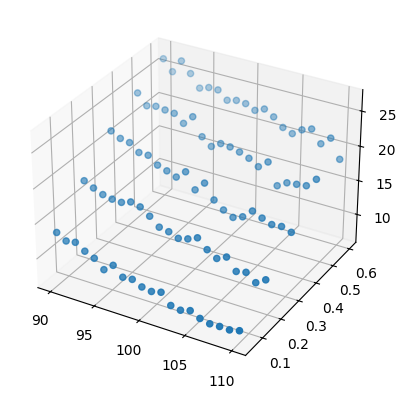

In [18]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(predictors[:, 0], predictors[:, 1], obs)

Now we fit the Gaussian Process. Note that the parameter $\alpha$ is additive noise to each measurement. That is, it's the quantity added to each diagonal element of the covariance matrix. It is used for tuning measurement noise in observations.

In [19]:
# prior mean is 0 everywhere by default
sq_exp_gp = GaussianProcessRegressor(
    kernel = kernels.ConstantKernel(100, constant_value_bounds='fixed') * \
             kernels.RBF(length_scale=[10, 0.1], length_scale_bounds='fixed'),
    optimizer=None,
    alpha=0.05,
    copy_X_train=True,
    random_state=1234
).fit(predictors, obs)

In [20]:
# check that this works as it's intended
print('V = 0.1 Level:', sq_exp_gp.predict([
    [95, 0.1],
    [100, 0.1]
]))

print('V = 0.2 Level:', sq_exp_gp.predict([
    [95, 0.2],
    [100, 0.2]
]))

# increases in v but decreases in s, good

V = 0.1 Level: [13.27773053 11.51667755]
V = 0.2 Level: [16.24809508 14.51407525]


## (b)

Now we fit a GP with a Matern kernel

In [21]:
matern_gp = GaussianProcessRegressor(
    kernel=kernels.ConstantKernel(100, constant_value_bounds='fixed') * kernels.Matern(nu=5/2), 
    # length scale is automatically optimized
    alpha=1, # increase observation noise to prevent overfitting
    n_restarts_optimizer = 4,
    copy_X_train=True,
    random_state=1234
).fit(predictors, obs)

In [22]:
# check that this is working as intended
print('V = 0.1 Level:', matern_gp.predict([
    [95, 0.1],
    [100, 0.1]
]))

print('V = 0.2 Level:', matern_gp.predict([
    [95, 0.2],
    [100, 0.2]
]))


V = 0.1 Level: [13.02209182 11.18446111]
V = 0.2 Level: [15.50102163 13.66733384]


## (c)

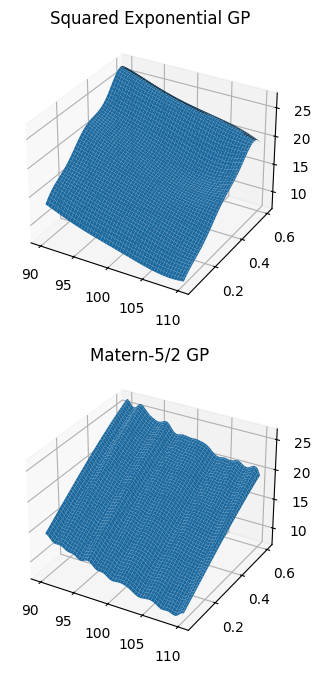

In [23]:
# Create the figure and subplots
fig = plt.figure(figsize=plt.figaspect(2)) # Adjust size as needed

x_train = np.linspace(90, 110, 100)
y_train = np.linspace(0.05, 0.6, 100)

X, Y = np.meshgrid(x_train, y_train)

formatted_inputs = np.array([[x, y] for x in x_train for y in y_train])
Z1 = sq_exp_gp.predict(formatted_inputs)
Z1 = Z1.reshape((len(x_train), len(y_train)))
Z1 = Z1.T
# for whatever reason, reshape doesn't properly format, it flips the columns and rows
# so i'm fixing it by taking the transpose


# First subplot
ax1 = fig.add_subplot(2, 1, 1, projection='3d')
ax1.set_title('Squared Exponential GP')

ax1.plot_surface(X, Y, Z1)

ax2 = fig.add_subplot(2, 1, 2, projection='3d')
ax2.set_title('Matern-5/2 GP')
Z2 = matern_gp.predict(formatted_inputs)
Z2 = Z2.reshape(len(x_train), len(y_train))
Z2 = Z2.T

ax2.plot_surface(X, Y, Z2)

In [24]:
sq_exp_pred, sq_exp_std = sq_exp_gp.predict([[100, 0.25]], return_std=True)
mat_pred, mat_std = matern_gp.predict([[100, 0.25]], return_std=True)

print('True Price: 15.60')
print('Squared Exp. GP Price:', sq_exp_pred, '\nSquared Exp. Standard Deviation:', sq_exp_std)
print('Matern GP Price:', mat_pred,'\nMatern Standard Deviation:', mat_std)

True Price: 15.60
Squared Exp. GP Price: [15.6106514] 
Squared Exp. Standard Deviation: [2.62962418]
Matern GP Price: [14.8914287] 
Matern Standard Deviation: [0.99949994]


*I am unable to compare this to results in Question 2 due to numerical instability*

We see that both curves are, for the most part, capturing the general shape of the data (namely, increasing in $v$ axis, decreasing in $s$). For fixed $v$, both curves are roughly linear in the negative $s$ direction for $s < 100$. There is a pattern of slight overfitting for the Matern GP, as shown with the oscillations in the $s$ axis, though this has been mostly dampened with the hyperparameter $\alpha$.

Emperically, the Squared Exponential mean (15.61) is much closer than the Matern mean (14.89) to the true option price (15.60). However, it's worth noting that the confidence levels for the Matern GP (0.999 std) is much tighter than the Squared Exp. GP (2.627 std). The true value is within 1 standard deviation of both means, so both models are doing a good job at predicting.

This echoes a bias-variance tradeoff to me. While the Squared Exp. model is far less biased, it has larger variance.